**Importing dependencies**

In [ ]:
import os, sys
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization


**Set the datagenerator and training parameters**

In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
IMAGE_SIZE = 256
target_size = [IMAGE_SIZE,IMAGE_SIZE]
TrainPathImages = "/content/drive/MyDrive/UNET_TVT/TRAIN/iimages"
TrainPathMasks = "/content/drive/MyDrive/UNET_TVT/TRAIN/mmasks"

ValPathImages = "/content/drive/MyDrive/UNET_TVT/VALIDATION/iimages"
ValPathMasks = "/content/drive/MyDrive/UNET_TVT/VALIDATION/mmasks"

TestPathImages = "/content/drive/MyDrive/UNET_TVT/TEST/iimages"
TestPathMasks = "/content/drive/MyDrive/UNET_TVT/TEST/mmasks"
initial_epochs = 35
final_epoch = 50
BATCH = 8  # batch size
LR = 1e-4  # Learning rate
AUTOTUNE = tf.data.experimental.AUTOTUNE

# set save path 
saveModelPath ='/content/drive/MyDrive/UNET_TVT/ZsavedModels/'
modelName = 'Unet_Optimizer_Nadam'

# Set path for model checkpoints
ckp_path = '/content/drive/MyDrive/UNET_TVT/ZmodelCheckPoint/'+ modelName+'/'


# Check whether the specified path exists or not
isExist = os.path.exists(ckp_path)

if not isExist:
  
  # Create a new directory because it does not exist 
  os.makedirs(ckp_path)
  print("The new directory is created!")
  print(ckp_path)

# **Data preprocessing**

**Data augmentation**

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce  [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

**Image augmentation in Keras using Keras ImageDataGenerator**

Keras ImageDataGenerator class provides a quick and easy way to augment your images. It provides a host of different augmentation techniques like standardization, rotation, shifts, flips, brightness change, and many more. You can find more on its [official documentation page](https://keras.io/preprocessing/image/).

However, the main benefit of using the Keras ImageDataGenerator class is that it is designed to provide real-time data augmentation. Meaning it is generating augmented images on the fly while your model is still in the training stage. How cool is that!

ImageDataGenerator class ensures that the model receives new variations of the images at each epoch. But it only returns the transformed images and does not add it to the original corpus of images. If it was, in fact, the case, then the model would be seeing the original images multiple times which would definitely overfit our model.

Another advantage of ImageDataGenerator is that it requires lower memory usage. This is so because without using this class, we load all the images at once. But on using it, we are loading the images in batches which saves a lot of memory.

The **flow_from_directory() method** allows you to read the images directly from the directory and augment them while the neural network model is learning on the training data.

The method expects that images belonging to different classes are present in different folders but are inside the same parent folder

**Train_generator**



```
flow_from_directory(
    directory, target_size=(256, 256), color_mode='rgb', classes=None,
    class_mode='categorical', batch_size=32, shuffle=True, seed=None,
    save_to_dir=None, save_prefix='', save_format='png',
    follow_links=False, subset=None, interpolation='nearest'
)

```



In [ ]:
# Data augmentation dictionary
data_aug_dict = dict(rescale=1./255,
                    rotation_range=10,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    shear_range=0.05,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest') 
'''
To generate image and mask at the same time
use the same seed for image_datagen and mask_datagen to ensure the
 transformation for image and mask is the same
if you want to visualize the results of generator, set save_to_dir = "your path"
'''
Timage_datagen = ImageDataGenerator(**data_aug_dict)
Tmask_datagen = ImageDataGenerator(**data_aug_dict)
# Provide the same seed and keyword arguments to the fit and flow methods
Image_train_generator = Timage_datagen.flow_from_directory(
    TrainPathImages,
    class_mode = None,
    color_mode = "rgb",
    target_size = target_size,
    batch_size = BATCH,
    save_to_dir = None,
    seed = SEED) 
# get the number of samples of train data
train_count = Image_train_generator.samples 

#==============================================================================
#                      Train masks
#==============================================================================
mask_Train_generator = Tmask_datagen.flow_from_directory(
    TrainPathMasks,
    class_mode = None,
    color_mode = "grayscale",
    target_size = target_size,
    batch_size = BATCH,
    save_to_dir = None,
    seed = SEED)# set as training data)
train_generator = zip(Image_train_generator,  mask_Train_generator)

Found 1776 images belonging to 1 classes.
Found 1776 images belonging to 1 classes.


**Validation_generator**

In [ ]:
# Using the same "Data augmentation dictionary" used in train generator
Vimage_datagen = ImageDataGenerator(**data_aug_dict)
Vmask_datagen = ImageDataGenerator(**data_aug_dict)

# Provide the same seed and keyword arguments to the fit and flow methods
Image_val_generator = Vimage_datagen.flow_from_directory(
    ValPathImages,
    class_mode = None,
    color_mode = "rgb",
    target_size = target_size,
    batch_size = BATCH,
    save_to_dir = None,
    seed = SEED) 
val_count = Image_val_generator.samples # get the number of samples of val data
#==============================================================================
#                                    validation masks
#==============================================================================
mask_Val_generator = Vmask_datagen.flow_from_directory(
    ValPathMasks,
    class_mode = None,
    color_mode = "grayscale",
    target_size = target_size,
    batch_size = BATCH,
    save_to_dir = None,
    seed = SEED)
validation_generator = zip(Image_val_generator,  mask_Val_generator)

Found 184 images belonging to 1 classes.
Found 184 images belonging to 1 classes.


**View some images and their corresponding masks**

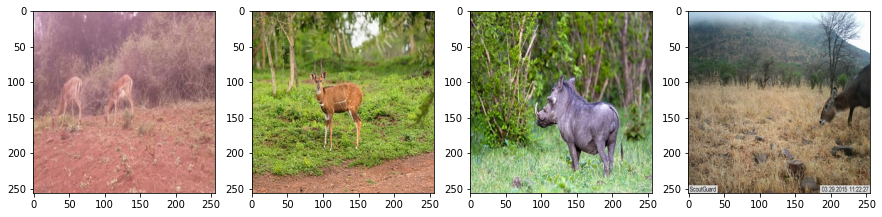

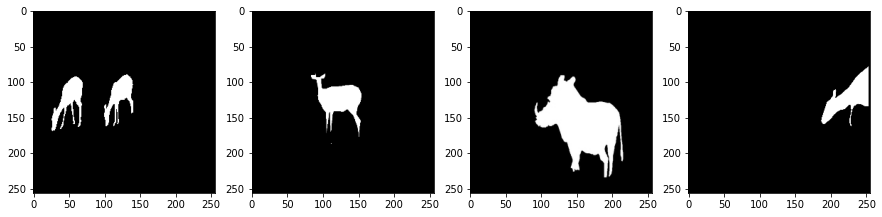

In [ ]:
def read_and_rgb(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    #print(x.shape)
    return x

image_path = "/content/drive/MyDrive/UNET_TVT/TRAIN/iimages"
mask_path = "/content/drive/MyDrive/UNET_TVT/TRAIN/mmasks"
fig = plt.figure(figsize=(15, 15))

a = fig.add_subplot(1, 4, 1)
image_file = os.path.join(image_path,Image_train_generator.filenames[56])
#print(image_file)
imgplot = plt.imshow(read_and_rgb(image_file))

a = fig.add_subplot(1, 4, 2)
image_file = os.path.join(image_path,Image_train_generator.filenames[277])
imgplot = plt.imshow(read_and_rgb(image_file))

a = fig.add_subplot(1, 4, 3)
image_file = os.path.join(image_path,Image_train_generator.filenames[1033])
imgplot = plt.imshow(read_and_rgb(image_file))

a = fig.add_subplot(1, 4, 4)
image_file = os.path.join(image_path,Image_train_generator.filenames[1533])
imgplot = plt.imshow(read_and_rgb(image_file))


#============== masks ===============================================
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
mask_file = os.path.join(mask_path,mask_Train_generator.filenames[56])
imgplot = plt.imshow(read_and_rgb(mask_file))

a = fig.add_subplot(1, 4, 2)
mask_file = os.path.join(mask_path,mask_Train_generator.filenames[277])
imgplot = plt.imshow(read_and_rgb(mask_file))

a = fig.add_subplot(1, 4, 3)
mask_file = os.path.join(mask_path,mask_Train_generator.filenames[1033])
imgplot = plt.imshow(read_and_rgb(mask_file))

a = fig.add_subplot(1, 4, 4)
mask_file = os.path.join(mask_path,mask_Train_generator.filenames[1533])
imgplot = plt.imshow(read_and_rgb(mask_file))
# /content/drive/MyDrive/UNET_TVT/TEST/iimages/images/21Sep05_17_59_09.jpg

**U-Net Model**

U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg, Germany. The network is based on the fully convolutional network and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations.

MobileNetV2 is a architecture that is optimized for mobile devices. It improves the state of the art performance of mobile models on multiple tasks and benchmarks as well as across a spectrum of different model sizes.

The model function is used to build the architecture for the UNet with pre-trained MobileNetV2. First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
def model():
    inputs = Input(shape=(256, 256, 3), name="input_image")
    #inputs = data_augmentation(inputs)
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=1)

    #Freeze the convolutional base
    encoder.trainable = False
    encoder(inputs,training=False)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [ ]:
model = model()
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                               

**Metrics**

Here, we define the dice coefficient which is used as the metric to measure the performance and the dice coefficient loss.

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

**Compile the model**

To train the architecture, we use Nadam optimizer with dice coefficient loss.

In [ ]:
#model = model()
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

**callbacks**

The callbacks are used while training a network. We used two callbacks:

ReduceLROnPlateau: Reduce learning when a monitored metric has stopped improving.


EarlyStopping: Stop training when a monitored metric has stopped improving.

In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=ckp_path,
    save_weights_only=True,
    monitor="val_loss",
    save_best_only=True)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    model_checkpoint_callback]

First we define the training and validation steps, which define the number of batches in an epoch. 

In [ ]:
train_steps = train_count//BATCH
valid_steps = val_count//BATCH

if train_count % BATCH != 0:
    train_steps += 1
if val_count % BATCH != 0:
    valid_steps += 1

**Train The model**

The fit function is used for training a UNet on the custom segmentation dataset.

In [ ]:
# train_generator,validation_generator
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=validation_generator,
                    steps_per_epoch=train_steps,
                    validation_steps=valid_steps,
                    callbacks=[callbacks])

Epoch 1/35
222/222 [==============================] - 860s 4s/step - loss: 0.5586 - dice_coef: 0.4414 - val_loss: 0.4127 - val_dice_coef: 0.5873 - lr: 1.0000e-04
Epoch 2/35
222/222 [==============================] - 69s 311ms/step - loss: 0.4155 - dice_coef: 0.5845 - val_loss: 0.3023 - val_dice_coef: 0.6977 - lr: 1.0000e-04
Epoch 3/35
222/222 [==============================] - 69s 310ms/step - loss: 0.3604 - dice_coef: 0.6396 - val_loss: 0.2619 - val_dice_coef: 0.7381 - lr: 1.0000e-04
Epoch 4/35
222/222 [==============================] - 64s 287ms/step - loss: 0.3113 - dice_coef: 0.6887 - val_loss: 0.2321 - val_dice_coef: 0.7679 - lr: 1.0000e-04
Epoch 5/35
222/222 [==============================] - 69s 312ms/step - loss: 0.2728 - dice_coef: 0.7272 - val_loss: 0.1984 - val_dice_coef: 0.8016 - lr: 1.0000e-04
Epoch 6/35
222/222 [==============================] - 64s 290ms/step - loss: 0.2434 - dice_coef: 0.7566 - val_loss: 0.1830 - val_dice_coef: 0.8170 - lr: 1.0000e-04
Epoch 7/35
222/222

**Store the history variables**

In [ ]:
"""Visualizing the training and Validation performance"""
die_C1 = history.history['dice_coef']
val_die_C1 = history.history['val_dice_coef']

loss1 = history.history['loss']
val_loss1 = history.history['val_loss']


resume_epoch = len(die_C1)
print('resume_epoch =')
print(resume_epoch)

resume_epoch =
24


# **Fine tuning**

In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

**Un-freeze the top layers of the model**

All you need to do is unfreeze the base_model(encoder) and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
def model():
    inputs = Input(shape=(256, 256, 3), name="input_image")
    #inputs = data_augmentation(inputs)
    
    encoder = MobileNetV2(input_tensor=inputs, weights=None, include_top=False, alpha=1)

    #unFreeze the convolutional base
    encoder.trainable = True
    # fine-tune from this onwards
    fine_tune_at = 100
    print(len(encoder.layers))
    #Freeze all the layers before the 'fine_tune_at' layer
    for layer in encoder.layers[:fine_tune_at]:
      layer.trainable = False
    encoder(inputs)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model2 = Model(inputs, x)
    return model2

**Compile the model again**

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
model = model()
opt = tf.keras.optimizers.Nadam(1e-5)
metrics = [dice_coef]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

154


In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=ckp_path,
    save_weights_only=True,
    monitor="val_loss",
    save_best_only=True)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    model_checkpoint_callback]

# The model weights (that are considered the best) are loaded into the model
# before continuing to train
model.load_weights(ckp_path)

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.

**Continue training the model**

In [17]:
#initial_epochs = 35
#final_epoch = 50
# train_generator,validation_generator
history_fine = model.fit(train_generator,
                    epochs=final_epoch,
                    validation_data=validation_generator,
                    steps_per_epoch=train_steps,
                    validation_steps=valid_steps,
                    initial_epoch = resume_epoch,
                    callbacks=[callbacks])

Epoch 25/50
222/222 [==============================] - 69s 290ms/step - loss: 0.1274 - dice_coef: 0.8726 - val_loss: 0.1232 - val_dice_coef: 0.8768 - lr: 1.0000e-04
Epoch 26/50
222/222 [==============================] - 63s 286ms/step - loss: 0.1152 - dice_coef: 0.8848 - val_loss: 0.1152 - val_dice_coef: 0.8848 - lr: 1.0000e-04
Epoch 27/50
222/222 [==============================] - 63s 286ms/step - loss: 0.1054 - dice_coef: 0.8946 - val_loss: 0.1032 - val_dice_coef: 0.8968 - lr: 1.0000e-04
Epoch 28/50
222/222 [==============================] - 63s 286ms/step - loss: 0.1066 - dice_coef: 0.8934 - val_loss: 0.1019 - val_dice_coef: 0.8981 - lr: 1.0000e-04
Epoch 29/50
222/222 [==============================] - 63s 283ms/step - loss: 0.1005 - dice_coef: 0.8995 - val_loss: 0.1137 - val_dice_coef: 0.8863 - lr: 1.0000e-04
Epoch 30/50
222/222 [==============================] - 63s 285ms/step - loss: 0.0999 - dice_coef: 0.9001 - val_loss: 0.1013 - val_dice_coef: 0.8987 - lr: 1.0000e-04
Epoch 31/5

**Visualize the finetuning process**

In [18]:
# add the new die coefficient, validation die coeffient, less and
# validation loss from fine-tuning to previous training values
die_C2 = history_fine.history['dice_coef']
val_die_C2 = history_fine.history['val_dice_coef']

loss2 = history_fine.history['loss']
val_loss2 = history_fine.history['val_loss']


die_C = [*die_C1,*die_C2] # unpack both iterables in a list literal
val_die_C = [*val_die_C1,*val_die_C2]
loss = [*loss1,*loss2]
val_loss =[*val_loss1,*val_loss2]

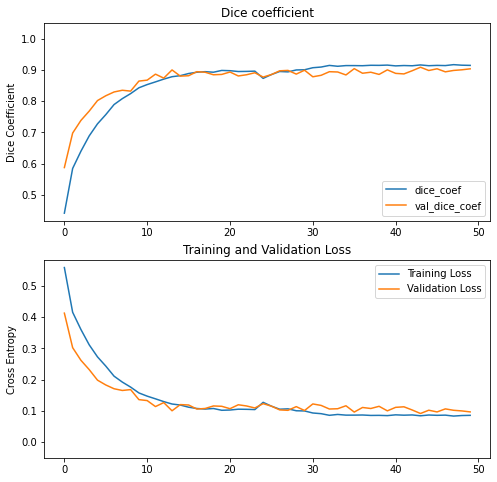

In [19]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(die_C, label='dice_coef')
plt.plot(val_die_C, label='val_dice_coef')
plt.legend(loc='lower right')
plt.ylabel('Dice Coefficient')
plt.ylim([min(plt.ylim()),1.05])
plt.title('Dice coefficient')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([-0.05,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

**which epoch has the minimum validation loss?**


In [20]:
#Find the minimum value of val_loss
min_val_loss = min(val_loss)
print('Minimum Validation loss = ')
print(min_val_loss)

#Find the index of the minimum value in val_loss
index_of_min_in_val_loss = val_loss.index(min_val_loss)
best_epoch = index_of_min_in_val_loss+1
print('Epoch with the minimum validation loss = ')
print(best_epoch)

Minimum Validation loss = 
0.09171070903539658
Epoch with the minimum validation loss = 
44


**save the best weights after training**


In [21]:
# The model weights (that are considered the best) are loaded into the model
# before saving
model.load_weights(ckp_path)
model.save(saveModelPath+modelName)
model.save(saveModelPath+modelName+'.h5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/UNET_TVT/ZsavedModels/Unet_Optimizer_Nadam/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


**Evaluation**

***Test data***

In [22]:
#TestPathImages = "/content/drive/MyDrive/UNET_TVT/TEST/iimages"
#TestPathMasks = "/content/drive/MyDrive/UNET_TVT/TEST/mmasks"


Test_Image_datagen = ImageDataGenerator(rescale=1./255)
Test_Mask_datagen = ImageDataGenerator(rescale=1./255)
# Provide the same seed and keyword arguments to the fit and flow methods
Image_Test_generator = Test_Image_datagen.flow_from_directory(
    TestPathImages,
    class_mode = None,
    color_mode = "rgb",
    target_size = target_size,
    batch_size = BATCH,
    save_to_dir = None,
    seed = SEED,
    shuffle=False) 
# get the number of samples of train data
test_count = Image_Test_generator.samples 

#==============================================================================
#                      Train masks
#==============================================================================
mask_Test_generator = Test_Mask_datagen.flow_from_directory(
    TestPathMasks,
    class_mode = None,
    color_mode = "grayscale",
    target_size = target_size,
    batch_size = BATCH,
    save_to_dir = None,
    seed = SEED,
    shuffle=False)# set as training data)
Test_generator = zip(Image_Test_generator,  mask_Test_generator)

print('Test samples =')
print(test_count)

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Test samples =
100


***Evaluate***

In [23]:
test_steps = test_count//BATCH
if test_count % BATCH != 0:
    test_steps += 1


model.evaluate(Test_generator , steps=test_steps)

13/13 [==============================] - 34s 3s/step - loss: 0.1062 - dice_coef: 0.8953


[0.10623513162136078, 0.8952614068984985]

In [24]:
def readImage(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    #from skimage import io
    #x = io.imread(path)
    return x

def readMask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    #from skimage import io
    #x = io.imread(path)
    #print(x.shape)
    return x
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In the below line of code takes the test dataset image, makes the prediction on it and then concatenate all the three images i.e., input image, ground truth and the predicted mask

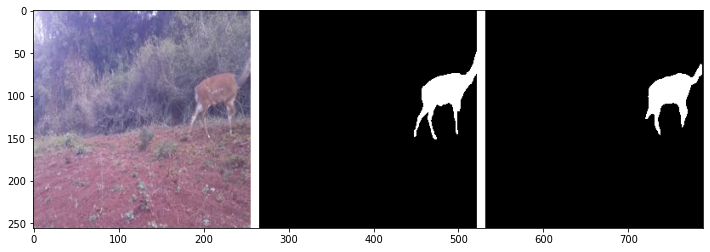

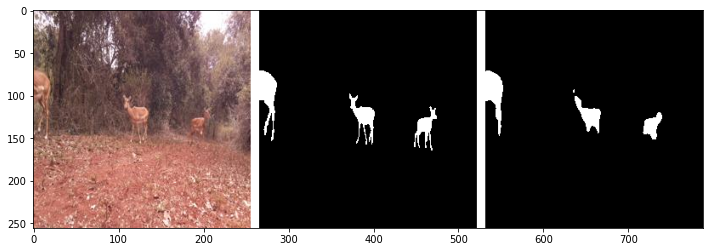

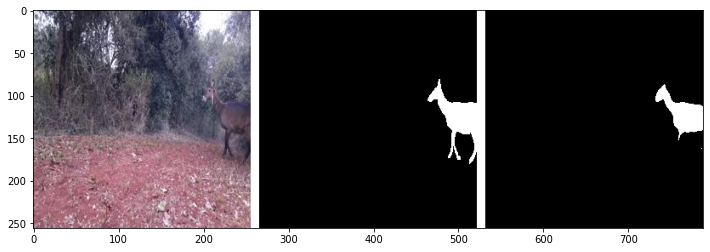

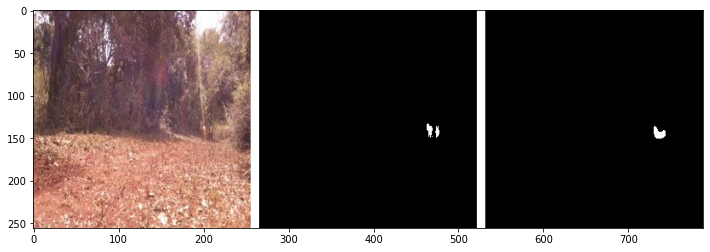

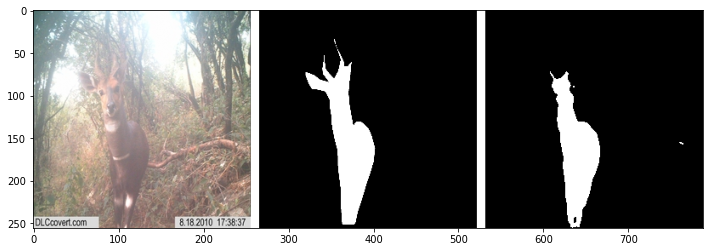

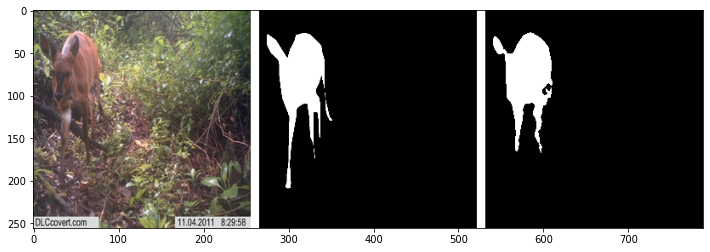

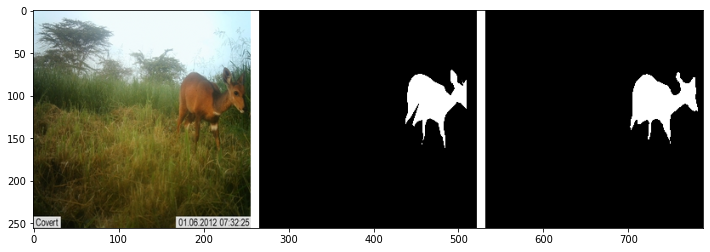

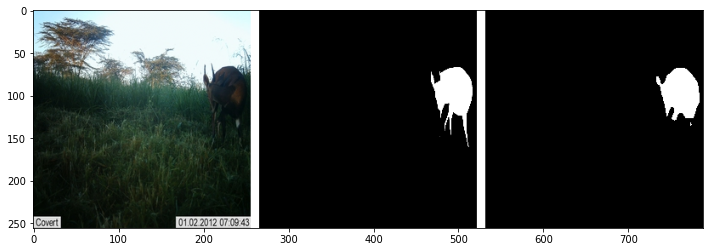

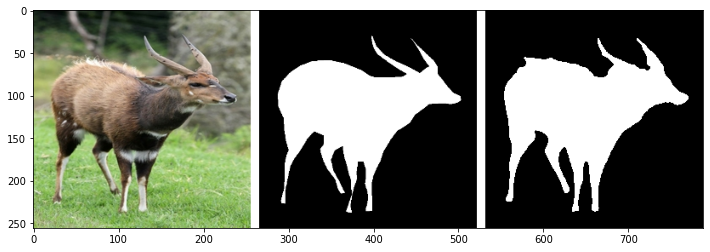

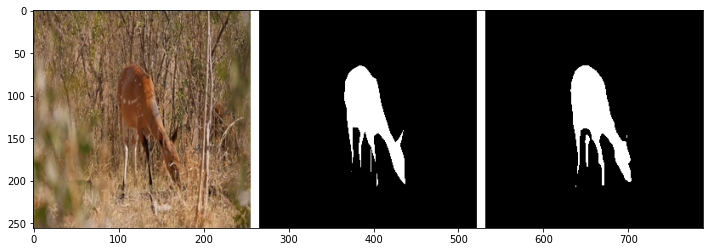

In [25]:
image_test = "/content/drive/MyDrive/UNET_TVT/TEST/iimages"
mask_test = "/content/drive/MyDrive/UNET_TVT/TEST/mmasks"

for i, (x, y) in enumerate(zip(Image_Test_generator.filenames[:10], mask_Test_generator.filenames[:10])):

    x = os.path.join(image_test,x)
    y = os.path.join(mask_test,y)
    x = readImage(x)
    y = readMask(y)
    #print(y.shape)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)